In [1]:
import numpy as np
from copy import deepcopy

import abipy
from abipy import abilab
from abipy.dfpt.converters import phonopy_to_abinit, abinit_to_phonopy

from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pymatgen_plotly import Figure


In [2]:
def plot_ifc(phonons, atom_ind, direction):

    super_structure = phonons.get_supercell()
    force_constants = phonons.get_force_constants()[atom_ind]

    direction = direction / np.linalg.norm(direction)

    forces = np.dot(force_constants, direction)
    magnitude = np.linalg.norm(forces, axis=1)[:, np.newaxis]

    # inds = np.ravel_multi_index(np.triu_indices(4), (4, 4))
    inds = range(16)
    cols = plotly.colors.DEFAULT_PLOTLY_COLORS

    fig = make_subplots(rows=2, cols=1, subplot_titles=("", "Logartihmic scale"))

    for (i, offset) in enumerate(inds):
        disp = (
            super_structure.positions[offset, 0:2] - super_structure.positions[0, 0:2]
        )

        z = super_structure.positions[offset::16, 2]
        sort_inds = np.argsort(super_structure.positions[offset::16, 2])

        fig.add_trace(
            go.Scatter(
                x=z[sort_inds],
                y=magnitude[offset::16, 0][sort_inds],
                name=f"{np.round(disp,3)}",
                line=dict(width=2, color=cols[i % 10]),
                legendgroup="group1",
            ),
            row=1,
            col=1,
        )

        fig.add_trace(
            go.Scatter(
                x=z[sort_inds],
                y=np.log10(magnitude[offset::16, 0][sort_inds]),
                name=f"{np.round(disp,3)}",
                line=dict(width=2, color=cols[i % 10]),
                legendgroup="group1",
                showlegend=False,
            ),
            row=2,
            col=1,
        )

    # edit axis labels
    fig["layout"]["xaxis"]["title"] = "z"
    fig["layout"]["xaxis2"]["title"] = "z"
    fig["layout"]["yaxis"]["title"] = "abs(F)"
    fig["layout"]["yaxis2"]["title"] = "log(abs(F))"

    fig.update_layout(
        height=600,
        width=800,
        legend_title_text="x-y offset:",
        title_text=f"The magnitude of interatomic force constants along {np.round(direction,3)}",
    )
    return fig

# Effect of truncating the IFCs

In [3]:
filename = 'data/reduced_cell/04_fcc100_dfpt_12/outdata/out_DDB'
ddb = abilab.abiopen(filename)
phonons = ddb.anaget_phonopy_ifc()

In [4]:
filename_bulk = 'data/reduced_cell/02_dfpt/outdata/out_DDB'
ddb_bulk = abilab.abiopen(filename_bulk)
phonons_bulk = ddb_bulk.anaget_phonopy_ifc()

/Users/fekad/.conda/envs/surfascope/lib/python3.9/site-packages/abipy/dfpt/converters.py:95: UserWarning: The hall number obtained based on the DDB symmetries differs from the one calculated with spglib: 424 versus 523. The conversion may be incorrect. Try changing symprec.
  warnings.warn("The hall number obtained based on the DDB symmetries differs "


In [5]:
filename_ref = 'data/reduced_cell/04_fcc100_dfpt_14/outdata/out_DDB'
ddb_ref = abilab.abiopen(filename_ref)
phonons_ref = ddb_ref.anaget_phonopy_ifc()

In [6]:
def truncate(phonons, distance):

    ifc = phonons.get_force_constants()
    for i, coords_i in enumerate(phonons.unitcell.positions):
        for j, coords_j in enumerate(phonons.supercell.positions):
            if abs(coords_j[2] - coords_i[2]) > distance:
                ifc[i, j, :, :] = 0

    phonons.set_force_constants(ifc)


def truncate(phonons, distance, periodic=False):

    ifc = phonons.get_force_constants()
    for i, coords_i in enumerate(phonons.unitcell.positions):
        for j, coords_j in enumerate(phonons.supercell.positions):
            if not periodic:
                if abs(coords_j[2] - coords_i[2]) > distance:
                    ifc[i, j, :, :] = 0
            else:
                if (
                    abs(coords_j[2] - coords_i[2]) > distance
                    and abs(
                        coords_j[2] - coords_i[2] - phonons_bulk.supercell.cell[2, 2]
                    )
                    > distance
                ):
                    ifc[i, j, :, :] = 0

    phonons.set_force_constants(ifc)


In [8]:
# phonons_trunk = deepcopy(phonons)
# truncate(phonons_trunk, 5., periodic=False)

phonons_trunk = deepcopy(phonons_bulk)
truncate(phonons_trunk, 5., periodic=True)

In [10]:
direction = [1,-1,0]
fig = plot_ifc(phonons_trunk, 0, direction)
fig.show()

/var/folders/r0/h6qcb1qs2zv9drfhsjnkxr340000gn/T/ipykernel_62496/3101284686.py:40: RuntimeWarning:

divide by zero encountered in log10



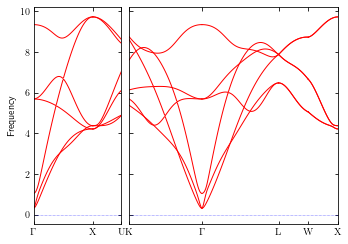

In [11]:
phonons_trunk.auto_band_structure()
phonons_trunk.plot_band_structure().show()

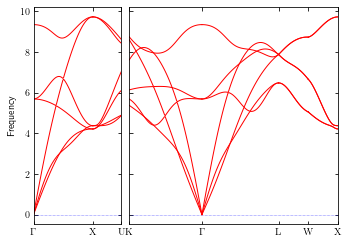

In [12]:
phonons_trunk_asr = deepcopy(phonons_trunk)
phonons_trunk_asr.symmetrize_force_constants()
phonons_trunk_asr.auto_band_structure()
phonons_trunk_asr.plot_band_structure().show()

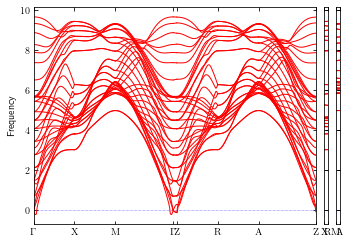

In [13]:
phonons.auto_band_structure()
phonons.plot_band_structure().show()

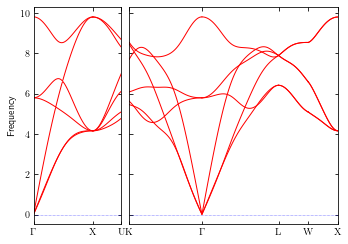

In [14]:
phonons_bulk.auto_band_structure()
phonons_bulk.plot_band_structure().show()

# Merging bulk and slab to reproduce reference calculation

In [ ]:
cell = phonons.unitcell.cell
coords = phonons.supercell.positions.reshape(12, 1, 4, 4, 3)
species = np.array(phonons.supercell.get_chemical_symbols()).reshape(12, 1, 4, 4)
ifc = phonons.force_constants.reshape(12, 12, 1, 4, 4, 3, 3)

extra_coords = phonons_bulk.supercell.positions.reshape(2, 4, 4, 4, 3)
extra_species = np.array(phonons_bulk.supercell.get_chemical_symbols()).reshape(2, 4, 4, 4)
extra_ifc = phonons_bulk.force_constants.reshape(2, 2, 4, 4, 4, 3, 3)

origin_offset = coords[6, 0, 0, 0, 2]
extra_height = phonons_bulk.unitcell.cell[2, 2]

# remove force constants between the two separated half
ifc[:6, 6:, :, :, :, :] = 0
ifc[6:, :6, :, :, :, :] = 0

new_cell = cell
new_cell[2, 2] += extra_height

new_coords = np.zeros((12 + 2, 1, 4, 4, 3))
new_coords[:6, :, :, :, :] = coords[:6, :, :, :, :]
new_coords[8:, :, :, :, :] = coords[6:, :, :, :, :]
new_coords[8:, :, :, :, 2] += extra_height

new_coords[6:8, 0, :, :, :] = extra_coords[:, 0, :, :, :]
new_coords[6:8, :, :, :, 2] += origin_offset

new_ifc = np.zeros((12 + 2, 12 + 2, 1, 4, 4, 3, 3))
# new_ifc = np.zeros((12+2,12+2,4,4,1,3,3)) ????
new_ifc[:6, :6, :, :, :, :, :] = ifc[:6, :6, :, :, :, :, :]
new_ifc[8:, 8:, :, :, :, :, :] = ifc[6:, 6:, :, :, :, :, :]

new_ifc[6:8, 6:8, 0, :, :, :, :] = extra_ifc[:, :, 0, :, :, :, :]

new_ifc[6:8, 8:10, 0, :, :, :, :] = extra_ifc[:, :, 1, :, :, :, :]
new_ifc[6:8, 4:6, 0, :, :, :, :] = extra_ifc[:, :, -1, :, :, :, :]

# symmetrising
new_ifc[8:10, 6:8, 0, :, :, :, :] = new_ifc[6:8, 8:10, 0, :, :, :, :]
new_ifc[4:6, 6:8, 0, :, :, :, :] = new_ifc[6:8, 4:6, 0, :, :, :, :]


In [ ]:
phonons_merged = deepcopy(phonons_ref)
phonons_merged.set_force_constants(new_ifc.reshape(14,-1,3,3))
direction = [1,-1,0]
fig = plot_ifc(phonons_merged, 6, direction)
fig.show()

In [ ]:
cell = phonons_ref.unitcell.cell
coords = phonons_ref.supercell.positions.reshape(14, 1, 4, 4, 3)

fig = Figure()
fig._add_unitcell(cell)
# fig._add_ball_and_stick(coords[:,0,0,0,:].reshape(-1,3), species[:,0,0,0])
# order: Z, Y, X
fig._add_ball_and_stick(coords[:, :, :, 1, :].reshape(-1, 3), 4 * 14 * ["Al"])
fig.show()


In [ ]:
fig = Figure()
fig._add_unitcell(cell)
# fig._add_ball_and_stick(coords[:,0,0,0,:].reshape(-1,3), species[:,0,0,0])
# order: Z, Y, X
fig._add_ball_and_stick(new_coords[:, 0, 0, 0, :].reshape(-1, 3), 4 * 14 * ["Al"])
fig.show()


In [ ]:
direction = [1,-1,0]
fig = plot_ifc(phonons_ref, 7, direction)
fig.show()

In [ ]:
phonons_ref.auto_band_structure()
phonons_ref.plot_band_structure().show()

In [ ]:
phonons_merged.auto_band_structure()
phonons_merged.plot_band_structure().show()

In [ ]:
phonons_merged_asr = deepcopy(phonons_merged)
phonons_merged_asr.symmetrize_force_constants()

In [ ]:
phonons_merged_asr.auto_band_structure()
phonons_merged_asr.plot_band_structure().show()